# 신용카드 이상탐지 데이터 다루기

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('fraud.csv')

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491134 entries, 0 to 491133
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  491134 non-null  object 
 1   cc_num                 491134 non-null  int64  
 2   merchant               491134 non-null  object 
 3   category               491134 non-null  object 
 4   amt                    491134 non-null  float64
 5   first                  491134 non-null  object 
 6   last                   491134 non-null  object 
 7   gender                 491134 non-null  object 
 8   street                 491134 non-null  object 
 9   city                   491134 non-null  object 
 10  state                  491134 non-null  object 
 11  zip                    491134 non-null  int64  
 12  lat                    491134 non-null  float64
 13  long                   491134 non-null  float64
 14  city_pop               491134 non-nu

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
1,2019-01-01 00:12:34,4956828990005111019,"fraud_Schultz, Simonis and Little",grocery_pos,44.71,Kenneth,Robinson,M,269 Sanchez Rapids,Elizabeth,...,40.6747,-74.2239,124967,Operational researcher,1980-12-21,09eff9c806365e2a6be12c1bbab3d70e,1325376754,40.079588,-74.848087,0
2,2019-01-01 00:17:16,180048185037117,fraud_Kling-Grant,grocery_net,46.28,Mary,Wall,F,2481 Mills Lock,Plainfield,...,40.6152,-74.4150,71485,Leisure centre manager,1974-07-19,19e23c6a300c774354417befe4f31f8c,1325377036,40.021888,-74.228188,0
3,2019-01-01 00:20:15,374930071163758,fraud_Deckow-O'Conner,grocery_pos,64.09,Daniel,Escobar,M,61390 Hayes Port,Romulus,...,42.2203,-83.3583,31515,Police officer,1971-11-05,6f363661ba6b55889e488dd178f2a0af,1325377215,42.360426,-83.552316,0
4,2019-01-01 00:23:41,2712209726293386,fraud_Balistreri-Nader,misc_pos,25.58,Jenna,Brooks,F,50872 Alex Plain Suite 088,Baton Rouge,...,30.4066,-91.1468,378909,"Designer, furniture",1977-02-22,1654da2abfb9e79a5f99167fc9779558,1325377421,29.737426,-90.853194,0


## step 1-1 사기거래 여부를 예측하는 데 불필요한 컬럼을 제거합니다.

In [4]:
# 사기 예측에 불필요한 단순 텍스트 및 일련번호 제거

df = df.drop(columns=['first', 'last', 'street', 'city', 'state', 'zip', 'trans_num', 'unix_time'])

print(df.columns.tolist())

['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'gender', 'lat', 'long', 'city_pop', 'job', 'dob', 'merch_lat', 'merch_long', 'is_fraud']


#

## step 1-2 최소 2개 이상의 새로운 피처(변수)를 생성해봅시다.
[힌트] 구매 금액, 시간 등의 변수를 이용할 수 있습니다.

In [ ]:
# 날짜/시간 기반 변수 생성 및 변환
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
df['is_night'] = df['hour'].apply(lambda x: 1 if x <= 6 else 0)

# 고객 패턴 변수 생성
## 고객별 평균 결제액 대비 현재 금액 비율
df['amt_to_user_avg'] = df['amt'] / df.groupby('cc_num')['amt'].transform('mean')
## 고객별 거래 빈도
df['user_trans_count'] = df.groupby('cc_num')['amt'].transform('count')

## step 2-1 데이터의 위도/경도 정보를 활용해볼 수 있을까요?

In [7]:
import numpy as np

# 하버사인(Haversine) 공식을 이용한 거리 계산 함수 정의
def get_distance(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

# 거리 변수 생성
df['dist_to_merch'] = get_distance(df['lat'], df['long'], df['merch_lat'], df['merch_long'])


## step 2-2 통계적 관점으로 접근하여 유용한 변수를 만들어낼 수 있을까요?

In [8]:
# 고객(cc_num)과 업종(category)별 평균(mean)과 표준편차(std) 계산
cat_info = df.groupby(['cc_num', 'category'])['amt'].agg(['mean', 'std']).reset_index()

# 계산된 통계 정보를 기존 데이터와 결합
df = df.merge(cat_info, on=['cc_num', 'category'], how='left')

# Z-Score 기반 파생 변수 생성
# 표준편차가 0인 경우(1e-9을 더해 에러를 방지)
df['cat_amt_z'] = (df['amt'] - df['mean']) / (df['std'] + 1e-9)

# 나이 피처 생성
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = 2026 - df['dob'].dt.year

In [9]:
# 파생 변수 컬럼 제거
drop_cols = [
    'cc_num', 'dob', 'lat', 'long', 'merch_lat', 'merch_long',
    'mean', 'std', 'merchant', 'job'
]

# 존재하는 컬럼 삭제
df_final = df.drop(columns=[c for c in drop_cols if c in df.columns])

# 범주형 변수 인코딩
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in ['gender', 'category']:
    if col in df_final.columns:
        df_final[col] = le.fit_transform(df_final[col].astype(str))

## 이상치 확인

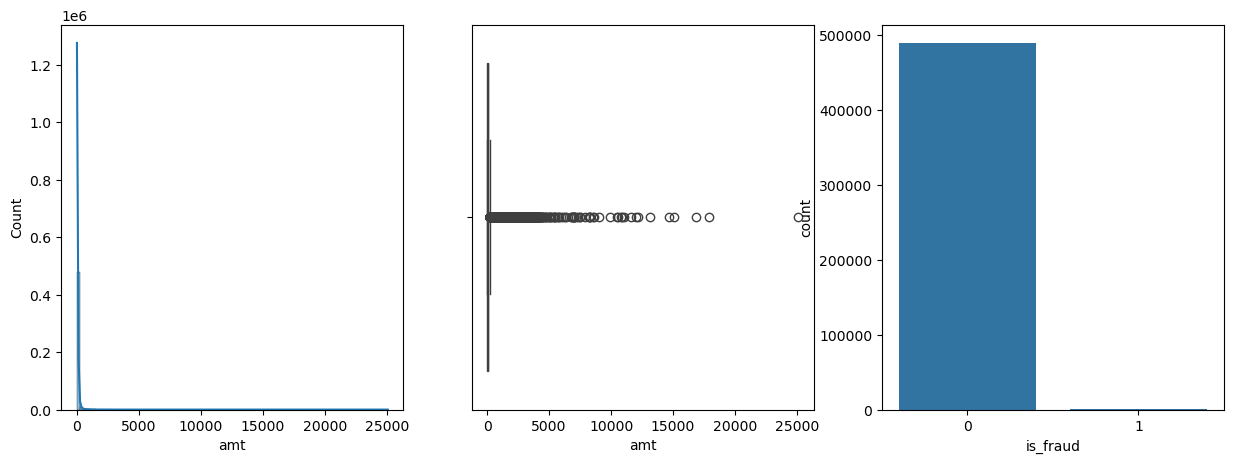

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# 결제 금액(amt)의 분포 - 히스토그램
sns.histplot(df['amt'], bins=100, ax=ax[0], kde=True)

# 결제 금액(amt)의 이상치 확인 - 박스플롯
sns.boxplot(x=df['amt'], ax=ax[1])

# 3. 타겟 변수(is_fraud)의 불균형 확인
sns.countplot(x='is_fraud', data=df, ax=ax[2])

plt.show()

## 사기 여부에 따른 패턴 분석(금액 및 시간)

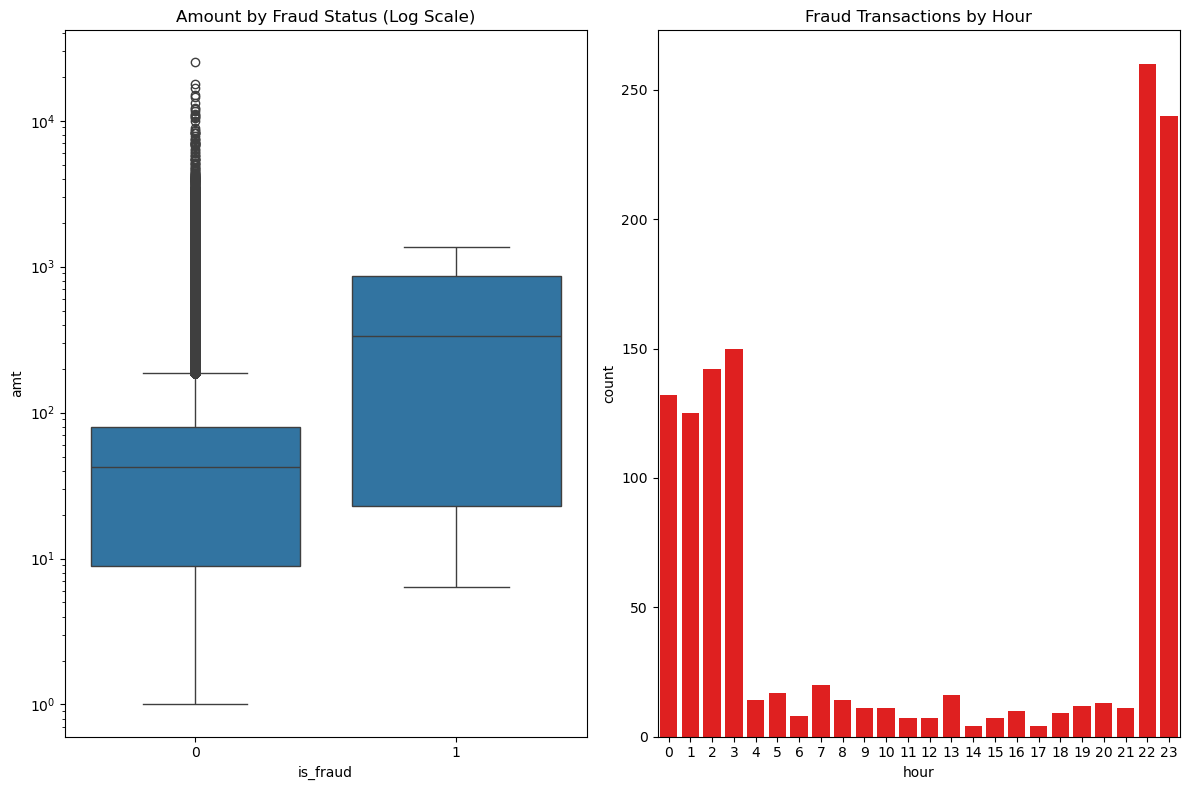

In [ ]:
plt.figure(figsize=(12, 8))

# 사기 여부에 따른 결제 금액 분포(이상치가 너무 커서 로그스케일로 확인)
plt.subplot(1, 2, 1)
sns.boxplot(x='is_fraud', y='amt', data=df)
plt.yscale('log')
plt.title('Amount by Fraud Status (Log Scale)')

# 시간대별 사기 발생 건수
plt.subplot(1, 2, 2)
fraud_only = df[df['is_fraud'] == 1]
sns.countplot(x='hour', data=fraud_only, color='red')
plt.title('Fraud Transactions by Hour')

plt.tight_layout()
plt.show()

## 이상치 처리

이상치 판단 기준: -98.09 미만 또는 187.38 초과
처리 후 결제 금액 최대값: 187.385
이상치로 분류된 거래 수: 0건


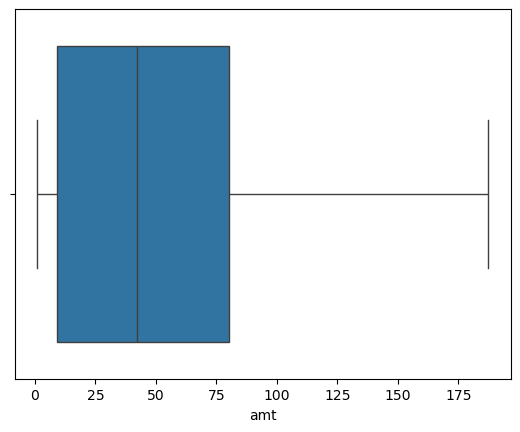

In [28]:
# 이상치 기준 계산
Q1 = df['amt'].quantile(0.25)
Q3 = df['amt'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"이상치 판단 기준: {lower_bound:.2f} 미만 또는 {upper_bound:.2f} 초과")

# 이상치 감지 및 새로운 피처 생성
df['is_amt_outlier'] = ((df['amt'] < lower_bound) | (df['amt'] > upper_bound)).astype(int)

#  이상치 수정 (Capping/Winsorization)
df['amt'] = np.where(df['amt'] > upper_bound, upper_bound, 
                     np.where(df['amt'] < lower_bound, lower_bound, df['amt']))

# 결과 확인
print(f"처리 후 결제 금액 최대값: {df['amt'].max()}")
print(f"이상치로 분류된 거래 수: {df['is_amt_outlier'].sum()}건")

sns.boxplot(x=df['amt'])
plt.show()

# 모델 학습(Random frorest)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

#  비수치형 컬럼 최종 제거
cols_to_drop = df.select_dtypes(include=['datetime64', 'object']).columns.tolist()
if 'is_fraud' in cols_to_drop:
    cols_to_drop.remove('is_fraud')

df_final = df.drop(columns=cols_to_drop)

# 특징(X)과 타겟(y) 분리
X = df_final.drop(columns=['is_fraud'])
y = df_final['is_fraud']

# 학습 및 테스트 데이터 분할 (8:2 비율)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 모델 생성 및 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

#  예측 및 결과 출력
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

print("--- [모델 평가 결과] ---")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# Confusion Matrix 출력
print("\n--- [Confusion Matrix] ---")
print(confusion_matrix(y_test, y_pred))

--- [모델 평가 결과] ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     97978
           1       0.93      0.54      0.69       249

    accuracy                           1.00     98227
   macro avg       0.96      0.77      0.84     98227
weighted avg       1.00      1.00      1.00     98227

ROC-AUC Score: 0.9558

--- [Confusion Matrix] ---
[[97968    10]
 [  114   135]]


# Feature Importance(변수 중요도 확인)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_56040\837111983.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')


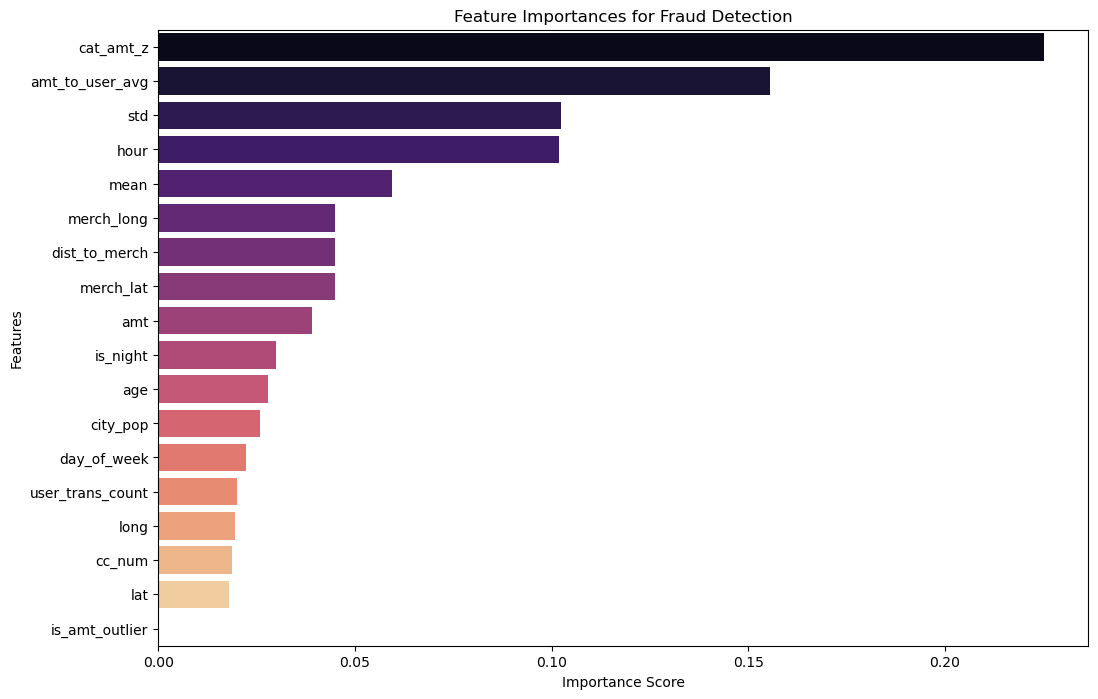

            Feature  Importance
15        cat_amt_z    0.225170
10  amt_to_user_avg    0.155423
14              std    0.102376
7              hour    0.101808
13             mean    0.059467


In [31]:

# 모델에서 피처 중요도 추출
importances = rf_model.feature_importances_
feature_names = X.columns

#  중요도를 데이터프레임으로 정리 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')
plt.title('Feature Importances for Fraud Detection')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# 상위 5개 주요 변수 출력
print(feature_importance_df.head(5))